In [25]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.use("pgf")
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import gymnasium as gym
# from trading_env1 import TradingEnv as TradingEnv1
import trading_env
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from gymnasium.utils.env_checker import check_env as gym_check_env
from stable_baselines3.common.env_checker import check_env as sb3_check_env
import numpy as np
import os
import pickle
import math

plt.rcParams['pgf.texsystem'] = "pdflatex"
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cmr12'
plt.rcParams['font.size'] = 20
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['figure.figsize'] = [6,12]
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = [
plt.rcParams['pgf.preamble'] = "\n".join([
    r"\usepackage{amsmath}"
    ])
n_colors = 2
plt.rcParams['axes.prop_cycle'] = plt.cycler("color", plt.cm.viridis(np.linspace(0,0.8,n_colors)))
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def sim_MC(funct, # function that determines # of shares to trade at each time step
           pos_args = [],
           key_args = {},
           T = 100, # total trading period
           lamb = 0.01, # magnitude of price impact
           gamma = 0.02, # std dev of alpha signal
           sigma = 0.1, # asset volatility
           c = 0.5, # concavity
           tau = 10, # impact decay
           theta = 5, # alpha decay
           init_q = 1000, # initial position
           target_q = 0, # target quantity
           S0 = 10, # initial price of asset
           n_MC = 1000, # no. of MC simulations,
           seed = 29, # rng seed
           save = False, # whether to save results
           fpath = None, # location to save
           ):
    '''
    Runs Monte Carlo simulations for optimal trade execution with temporary price impact for a given trading strategy funct, returns average of relevant quantities
    '''

    rng = np.random.default_rng(seed)

    J = np.zeros((n_MC, T)) # EWMA of cumulative order flow
    I = np.zeros((n_MC, T)) # price impact
    Q = np.zeros((n_MC, T+1)) # position
    Y = np.zeros((n_MC, T+1)) # P&L
    alpha = np.zeros((n_MC, T)) # alpha signal
    S = np.zeros((n_MC, T+1)) # unperturbed price
    P = np.zeros((n_MC, T)) # perturbed price
    x = np.zeros((n_MC, T)) # trade quantity

    # Initialize starting values
    Q[:,0] = init_q
    Y[:,0] = 0
    S[:,0] = S0
    
    # key_args['tot_q'] = end_pos - init_pos
    # key_args['t_steps'] = T

    for i in range(T):
        # print(f"\ni: {i}")
        # print(f"S: {S[:,i]}")
        # print(f"Q: {Q[:,i]}")
        # print(f"Y: {Y[:,i]}")
        if i == 0:
            alpha[:,i] = rng.normal(scale = gamma, size = n_MC)
        else:
            alpha[:,i] = np.exp(-1/theta) * alpha[:,i-1] + rng.normal(scale = gamma, size = n_MC)
        key_args['alpha'] = alpha[:,i]
        key_args['rem_q'] = target_q - Q[:,i]
        key_args['rem_t'] = np.ones(n_MC) * (T-i)
        
        if i == 0: 
            key_args['J'] = np.zeros(n_MC)
        else:
            key_args['J'] = J[:,i-1]
            
        # print(key_args['J'])
        # print(J[:,i-1])
        # print(key_args['alpha'])
        # print(key_args['rem_q'])
        # print(Q[:,i-1])
        # print(key_args['rem_t'])
        
        if i == T-1: # if at the last time step, need to reach target_q in next step
            x[:,i] = key_args['rem_q']
        else:
            # input function gives execution price as function of quantity,
            # need to know decay function, alpha, how long it decays
            x[:,i] = funct(*pos_args, **key_args)
        
        # print(f"x: {x[:,i]}")

        # Calculate impact and perturbed price
        if i == 0:
            J[:,i] = x[:,i]
        else:
            J[:,i] = np.exp(-1/tau) * J[:,i-1] + x[:,i]
        if c == 0.5:
            I[:,i] = lamb * np.sign(J[:,i]) * np.sqrt(abs(J[:,i]))
        else:
            I[:,i] = lamb * np.sign(J[:,i]) * abs(J[:,i]) ** c
        P[:,i] = S[:,i] + I[:,i]

        # Calculate for next time step
        S[:,i+1] = S[:,i] + alpha[:,i] + rng.normal(scale = sigma, size = n_MC)
        Q[:,i+1] = Q[:,i] + x[:,i]
        Y[:,i+1] = Y[:,i] - x[:,i] * I[:,i] + Q[:,i+1] * (S[:,i+1]-S[:,i])
        
    #     print(f"J: {J[:,i]}")
    #     print(f"I: {I[:,i]}")
    #     print(f"P: {P[:,i]}")
    
    # print(f"final S: {S[:,i+1]}")
    # print(f"final Q: {Q[:,i+1]}")
    # print(f"final Y: {Y[:,i+1]}")

    # Take mean over all MC simulations
    avg_x = np.mean(x, axis = 0)
    avg_Q = np.mean(Q, axis = 0)
    avg_Y = np.mean(Y, axis = 0)
    avg_alpha = np.mean(alpha, axis = 0)
    avg_J = np.mean(J, axis = 0)
    avg_I = np.mean(I, axis = 0)
    avg_S = np.mean(S, axis = 0)
    avg_P = np.mean(P, axis = 0)
    
    
    data = pd.DataFrame({
        'J': avg_J,
        'I': avg_I,
        'P': avg_P,
        'x': avg_x,
        'alpha': avg_alpha
        })
    
    data = pd.concat([data, pd.DataFrame({'S': avg_S, 'Q': avg_Q,'Y': avg_Y})], axis = 1)

    if save:
        with open(fpath + '.pkl', 'wb') as file:
            pickle.dump(data, file)
    return data

def x_RL_model(algo, path_to_model, J, alpha, rem_q, rem_t):
    if algo == 'PPO':
        model = PPO.load(path_to_model)
    t = 100 - rem_t
    alpha_std = 0.02*np.sqrt((1-np.exp(-2*(t+1)/5))/(1-np.exp(-2/5)))
    RL_obs = np.array([-J/500-1, alpha/alpha_std, -rem_q/500-1, rem_t/50-1]).T
    RL_action = np.squeeze(model.predict(RL_obs, deterministic = True)[0])
    return np.multiply((RL_action+1)/2, rem_q)

def plot_multi_results1(f_title, df, ncols = 2, save_fig=False, fpath=""):
    '''
    Plot averages of multidimensional MC sim with option to save fig
    data is a dict
    '''

    # Create a figure and axis
    N = 8              
    ncols = 2
    fig, axes = plt.subplots(ncols = ncols, nrows = math.ceil(N/ncols), layout='constrained',figsize=(8*ncols, 6 * math.ceil(N/ncols)))

    # Columns to plot
    cols = ['Q', 'x', 'alpha', 'J', 'Y', 'I', 'S', 'P']
    ylabs = [r"\# of shares", r"\# of shares", r"\$", r"\# of shares", r"\$", r"\$", r"\$"]
    titles = [r"Position ($\mathbf{Q_t}$)", r"Shares Traded ($\mathbf{x_t}$)", r"Price Signal ($\mathbf{\alpha_t}$)", r"EWMA of Cumulative Order Flow ($\mathbf{J_t}$)", r"P\&L ($\mathbf{Y_t}$)", r"Price Impact ($\mathbf{I_t}$)", r"Asset Price"]

    # if want to plot only P and not S
    # for i, c in enumerate(ylabs):
    #     leg_labels = []
    #     for p in df.keys():
    #         axes[i//2, i%2].plot(df[p][cols[i]], ".-", label = rf"$p={p:.2f}$")

    #         # Calculate final value
    #         final_val = df[p][cols[i]].iloc[len(df[p])-1]
    #         leg_labels.append(rf"$p={p:.2f}$, {final_val:.2f}")

    for i, j in enumerate(ylabs):
        r = i//ncols
        c = i%ncols
        lines = []
        leg_labels = []
        for p in df.keys():
            if i < 6:
                l, = axes[r,c].plot(df[p][cols[i]], ".-", label = rf"{p}")

                # Calculate final value
                final_val = df[p][cols[i]].iloc[df[p][cols[i]].last_valid_index()]
            else:
                axes[r,c].plot(df[p][cols[i]], ".-", label = rf"{p}")
                l, = axes[r,c].plot(df[p][cols[i+1]], "v-", c = axes[r, c].lines[-1].get_c(), label = rf"{p}")

                # Calculate final value of P
                final_val = df[p][cols[i+1]].iloc[df[p][cols[i+1]].last_valid_index()]

            lines.append(l)
            leg_labels.append(rf"{p}, {final_val:.3f}")

        axes[r,c].set_xlabel("Time")
        axes[r,c].set_ylabel(j)
        axes[r,c].set_title(titles[i], fontweight = 'heavy')
        axes[r,c].ticklabel_format(style='sci',axis='y')
        # if i < 5: axes[r,c].legend(lines, leg_labels, ncols = 2, prop = {'size': 12})
        # elif i == 6:
        if i ==6:
            # leg1 = axes[r,c].legend(lines, leg_labels, ncols = 2, prop = {'size': 12}, loc = 'lower left')
            # axes[r,c].add_artist(leg1)
            handles = [Line2D([], [], marker=marker) for marker in ['.', 'v']]
            axes[r,c].legend(handles = handles, labels = [r'$S_t$', r'$P_t$'], prop = {'size': 15})
            
    # first create a dummy legend, so fig.tight_layout() makes enough space
    axes[0, 0].legend(handles=axes[0, 0].lines[:1], bbox_to_anchor=(0.25, 1.12), loc='lower left')
    fig.tight_layout(pad=3)

    # now create the real legend
    axes[0, 0].legend(handles=axes[0, 0].lines, ncols = len(df.keys()), bbox_to_anchor=(1.15, 1.12), loc='lower center', fontsize=18)

    final_Y = np.array([df[x]['Y'].iloc[-1] for x in df.keys()])
    axes[(i+1)//ncols, (i+1)%ncols].plot(df.keys(), final_Y, 'o-')
    axes[(i+1)//ncols, (i+1)%ncols].set_title(r"Final P\&L for Varying $\mathbf{{p}}$", fontweight ='heavy')
    axes[(i+1)//ncols, (i+1)%ncols].set_xlabel(r"$p$")
    axes[(i+1)//ncols, (i+1)%ncols].set_ylabel(r"\$")

    fig.suptitle(f"{f_title}", fontweight="heavy")

    # Adjust layout to prevent clipping of titles
    fig.tight_layout()

    # Adjust layout to prevent clipping of titles
    fig.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)

    # Save figure
    if save_fig:
        fig.savefig(fpath, bbox_inches='tight', dpi = 600)

    return fig

/tmp/ipykernel_1196513/710947052.py:196: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=3)


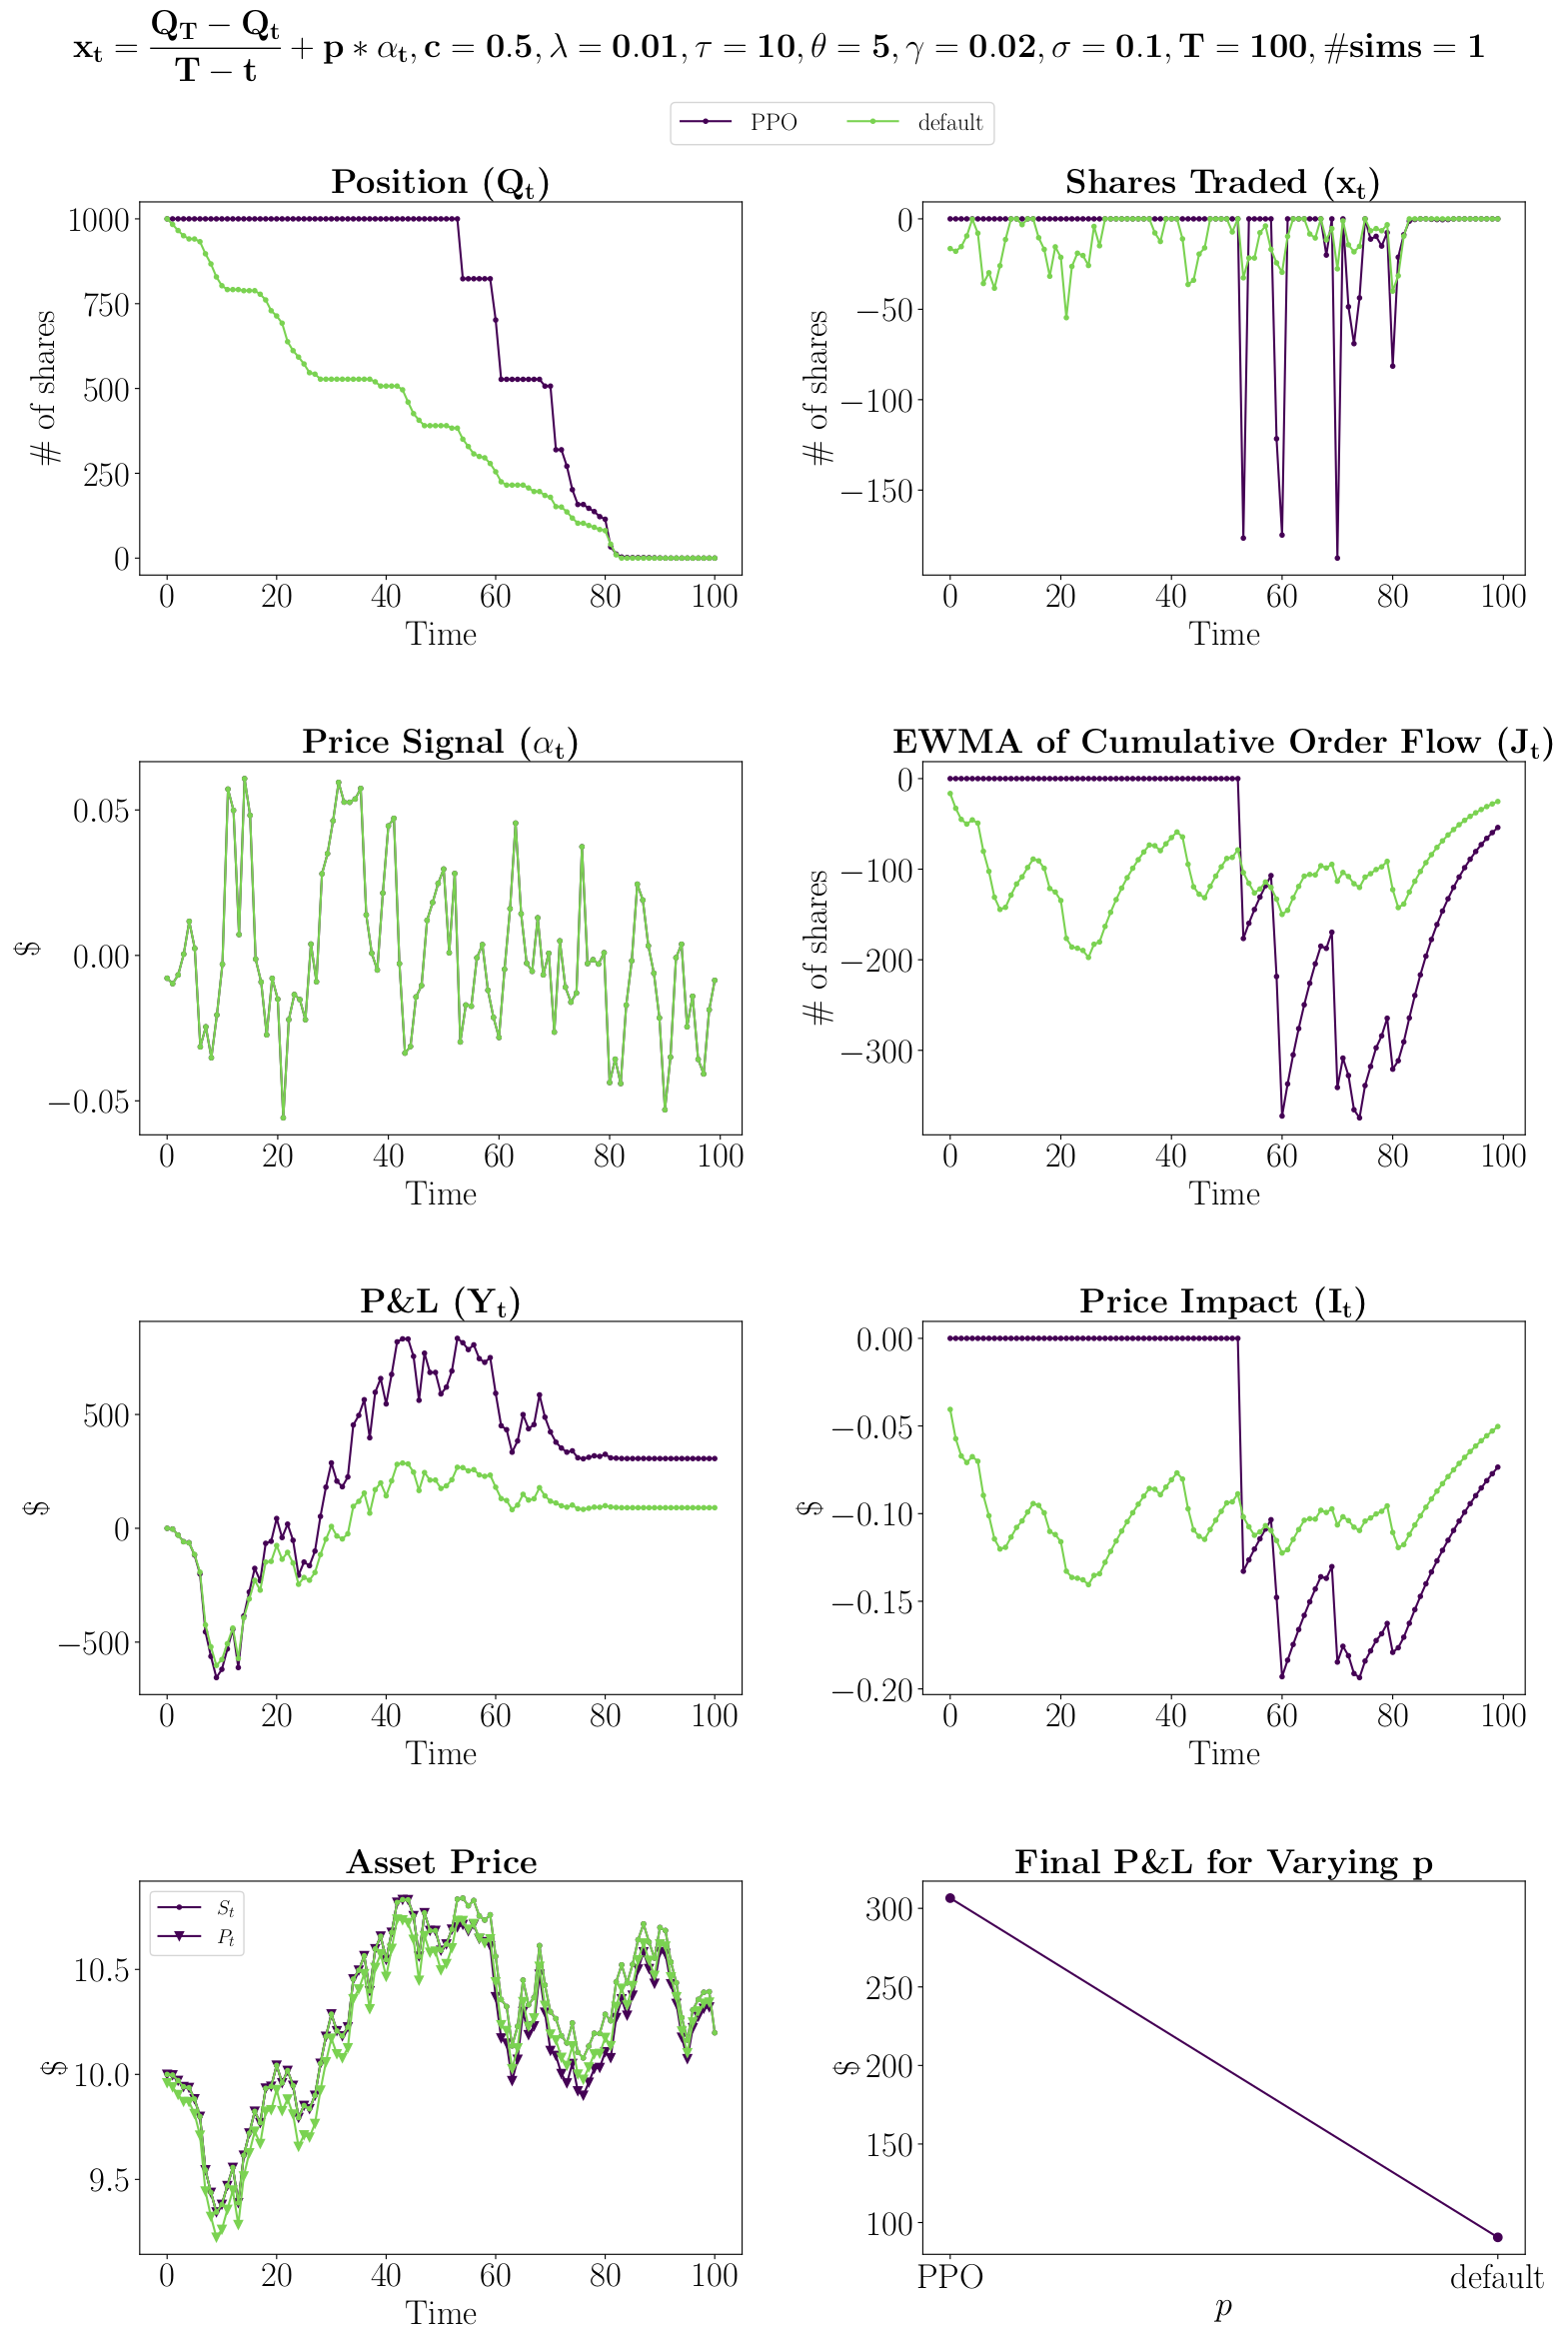

In [24]:
kwargs = {'algo': 'PPO',
          'path_to_model': '/scratch/network/efyoung/seniorthesis/final_ppo_s6/logs/ppo/Trading-v0_1/best_model.zip'
         }
params = {
    'init_q': 1000,
    'target_q': 0,
    'c': 0.5,
    'lamb': 0.01,
    'tau': 10,
    'theta': 5,
    'gamma': 0.02,
    'T': 100,
    'sigma': 0.1,
    'n_MC': 1,
}

d = {}
d['PPO'] = sim_MC(x_RL_model, key_args = kwargs, **params)
p=821.466
d['default'] = sim_MC(const_num_alpha_only_sell, key_args = {'p': 821.466}, **params)
plot_multi_results1(rf"$\mathbf{{x_t=\frac{{Q_T-Q_t}}{{T-t}}+p*\alpha_t,c={params['c']},\lambda={params['lamb']},\tau={params['tau']},\theta={params['theta']},\gamma={params['gamma']},\sigma={params['sigma']},T={params['T']},\#sims={params['n_MC']}}}$", d, save_fig=True, fpath = "/scratch/network/efyoung/seniorthesis/plots/PPO.pdf")

In [18]:
def plot_results(f_title, df, save_fig = False, fpath = ""):
    '''
    Plot averages of MC sim with option to save fig
    '''
    
    # Create a figure and axis
    N = 6
    ncols = 2
    fig, axes = plt.subplots(ncols = ncols, nrows = math.ceil(N/ncols), layout='constrained', figsize=(8*ncols, 6 * math.ceil(N/ncols)))

    # Columns to plot
    cols = ['Q', 'alpha', 'J', 'Y', 'I', 'S', 'P']
    ylabs = [r"\# of Shares", r"\$", r"\# of Shares", r"\$", r"\$", r"\$"]
    titles = [r"Position ($\mathbf{Q_t}$)", r"Price Signal ($\mathbf{\alpha_t}$)", r"EWMA of Cumulative Order Flow ($\mathbf{J_t}$)", r"P\&L ($\mathbf{Y_t}$)", r"Price Impact ($\mathbf{I_t}$)", r"Asset Price"]

    for i, j in enumerate(ylabs):
        r = i//ncols
        c = i%ncols
        if i < 5:
            axes[r,c].plot(df[cols[i]], ".-")
        else:
            axes[r,c].plot(df[cols[i]], ".-", label = r"$\mathbf{S_t}$")
            axes[r,c].plot(df[cols[i+1]], "v-", label = r"$\mathbf{P_t}$", c = 'blue')
            axes[r,c].legend()
            last_val = df[cols[i+1]].iloc[df[cols[i+1]].last_valid_index()]
            axes[r,c].text(df[cols[i+1]].last_valid_index() -10, last_val+0.005, f'{last_val:.3f}', va='bottom')

        # Annotate value at last time step
        last_val = df[cols[i]].iloc[df[cols[i]].last_valid_index()]
        if i == 0:
            axes[r,c].text(df[cols[i]].last_valid_index() - 7.5, last_val + 100, f'{last_val:.3f}', va='bottom')
        if i == 2:
            axes[r,c].text(df[cols[i]].last_valid_index() - 15, last_val + 5, f'{last_val:.3f}', va='bottom')
        if i == 4:
            axes[r,c].text(df[cols[i]].last_valid_index() - 10, last_val + 0.005, f'{last_val:.3f}', va='bottom')
        if i == 1:
            axes[r,c].text(df[cols[i]].last_valid_index() - 5, last_val+1e-5, f'{last_val:.3f}', va='bottom')
        if i == 3:
            axes[r,c].text(df[cols[i]].last_valid_index() - 12, last_val+15, f'{last_val:.3f}', va='bottom')
        if i == 5:
            axes[r,c].text(df[cols[i]].last_valid_index() -10, last_val-0.01, f'{last_val:.3f}', va='bottom')
        
        axes[r,c].set_xlabel("Time")
        axes[r,c].set_ylabel(j)
        axes[r,c].set_title(titles[i], fontweight = "heavy")

    fig.suptitle(f"{f_title}", fontsize = 24, fontweight = "heavy")

    # Adjust layout to prevent clipping of titles
    fig.tight_layout()

    # Adjust layout to prevent clipping of titles
    fig.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)

    # Save figure
    if save_fig:
        fig.savefig(fpath, bbox_inches='tight', dpi = 600)
    return fig


def plot_multi_results(f_title, df, ncols = 2, save_fig=False, fpath=""):
    '''
    Plot averages of multidimensional MC sim with option to save fig
    data is a dict
    '''

    # Create a figure and axis
    N = 8              
    ncols = 2
    fig, axes = plt.subplots(ncols = ncols, nrows = math.ceil(N/ncols), layout='constrained', figsize=(8*ncols, 6 * math.ceil(N/ncols)))

    # Columns to plot
    cols = ['Q', 'x', 'alpha', 'J', 'Y', 'I', 'S', 'P']
    ylabs = [r"\# of shares", r"\# of shares", r"\$", r"\# of shares", r"\$", r"\$", r"\$"]
    titles = [r"Position ($\mathbf{Q_t}$)", r"Shares Traded ($\mathbf{x_t}$)", r"Price Signal ($\mathbf{\alpha_t}$)", r"EWMA of Cumulative Order Flow ($\mathbf{J_t}$)", r"P\&L ($\mathbf{Y_t}$)", r"Price Impact ($\mathbf{I_t}$)", r"Asset Price"]

    # if want to plot only P and not S
    # for i, c in enumerate(ylabs):
    #     leg_labels = []
    #     for p in df.keys():
    #         axes[i//2, i%2].plot(df[p][cols[i]], ".-", label = rf"$p={p:.2f}$")

    #         # Calculate final value
    #         final_val = df[p][cols[i]].iloc[len(df[p])-1]
    #         leg_labels.append(rf"$p={p:.2f}$, {final_val:.2f}")

    for i, j in enumerate(ylabs):
        r = i//ncols
        c = i%ncols
        lines = []
        leg_labels = []
        for p in df.keys():
            if i < 6:
                l, = axes[r,c].plot(df[p][cols[i]], ".-", label = rf"$p={p:.2f}$")

                # Calculate final value
                final_val = df[p][cols[i]].iloc[df[p][cols[i]].last_valid_index()]
            else:
                axes[r,c].plot(df[p][cols[i]], ".-", label = rf"$p={p:.2f}$")
                l, = axes[r,c].plot(df[p][cols[i+1]], "v-", c = axes[r, c].lines[-1].get_c(), label = rf"$p={p:.2f}$")

                # Calculate final value of P
                final_val = df[p][cols[i+1]].iloc[df[p][cols[i+1]].last_valid_index()]

            lines.append(l)
            leg_labels.append(rf"$p={p:.2f}$, {final_val:.3f}")

        axes[r,c].set_xlabel("Time")
        axes[r,c].set_ylabel(j)
        axes[r,c].set_title(titles[i], fontweight = 'heavy')
        axes[r,c].ticklabel_format(style='sci',axis='y')
        # if i < 5: axes[r,c].legend(lines, leg_labels, ncols = 2, prop = {'size': 12})
        # elif i == 6:
        if i ==6:
            # leg1 = axes[r,c].legend(lines, leg_labels, ncols = 2, prop = {'size': 12}, loc = 'lower left')
            # axes[r,c].add_artist(leg1)
            handles = [Line2D([], [], marker=marker) for marker in ['.', 'v']]
            axes[r,c].legend(handles = handles, labels = [r'$S_t$', r'$P_t$'], prop = {'size': 15})
            
    # first create a dummy legend, so fig.tight_layout() makes enough space
    axes[0, 0].legend(handles=axes[0, 0].lines[:1], bbox_to_anchor=(0.25, 1.12), loc='lower left')
    fig.tight_layout(pad=2)

    # now create the real legend
    axes[0, 0].legend(handles=axes[0, 0].lines, ncols = len(df.keys()), bbox_to_anchor=(1.15, 1.12), loc='lower center', fontsize=18)

    final_Y = np.array([df[x]['Y'].iloc[-1] for x in df.keys()])
    axes[(i+1)//ncols, (i+1)%ncols].plot(df.keys(), final_Y, 'o-')
    axes[(i+1)//ncols, (i+1)%ncols].set_title(r"Final P\&L for Varying $\mathbf{{p}}$", fontweight ='heavy')
    axes[(i+1)//ncols, (i+1)%ncols].set_xlabel(r"$p$")
    axes[(i+1)//ncols, (i+1)%ncols].set_ylabel(r"\$")

    fig.suptitle(f"{f_title}", fontweight="heavy")

    # Adjust layout to prevent clipping of titles
    fig.tight_layout()

    # Adjust layout to prevent clipping of titles
    fig.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)

    # Save figure
    if save_fig:
        fig.savefig(fpath, bbox_inches='tight', dpi = 600)

    return fig

In [62]:
x

,J,I,P,x,alpha,S,Q,Y
0,0.000000,0.000000,10.000000,0.000000,-0.002450,10.000000,1000.000000,0.000000
1,0.000000,0.000000,9.996217,0.000000,-0.022242,9.996217,1000.000000,-3.782845
2,0.000000,0.000000,9.950358,0.000000,0.001959,9.950358,1000.000000,-49.641607
3,0.000000,0.000000,9.982694,0.000000,-0.008374,9.982694,1000.000000,-17.305890
4,0.000000,0.000000,10.032554,0.000000,-0.010708,10.032554,1000.000000,32.554209
...,...,...,...,...,...,...,...,...
96,-38.449681,-0.058872,9.531145,-0.000254,-0.001090,9.590016,0.065866,61.593214
97,-34.803060,-0.056014,9.615437,-0.012350,-0.004963,9.671450,0.065612,61.598379
98,-31.513430,-0.053310,9.720540,-0.022319,-0.013654,9.773851,0.053262,61.610690
99,-28.545473,-0.050753,9.701365,-0.030943,-0.018695,9.752118,0.030943,61.612799


In [4]:
def const_num_alpha_only_sell(p, rem_t, rem_q, alpha, **kwargs):
    '''
    Calculates the number of shares to trade for constant fraction plus alpha (can only sell)
    '''
    x = np.minimum(rem_q/rem_t + p * alpha, 0)
    return np.maximum(x, rem_q)
d = {}
params = {
    'init_q': 1000,
    'target_q': 0,
    'c': 0.5,
    'lamb': 0.01,
    'tau': 10,
    'theta': 5,
    'gamma': 0.02,
    'T': 100,
    'sigma': 0.1,
    'n_MC': 1,
}
ps = [700.0,750.0,800.0,850.0,900.0,950.0]
for i, p in enumerate(ps):
    params['seed'] = i
    d[p] = sim_MC(const_num_alpha_only_sell, key_args = {'p': p}, **params)

plot_multi_results(rf"$\mathbf{{x_t=\frac{{Q_T-Q_t}}{{T-t}}+p*\alpha_t,c={params['c']},\lambda={params['lamb']},\tau={params['tau']},\theta={params['theta']},\gamma={params['gamma']},\sigma={params['sigma']},T={params['T']},\#sims={params['n_MC']}}}$", d, save_fig=True, fpath = "/scratch/network/efyoung/seniorthesis/plots/one_traj.pdf")

NameError: name 'plot_multi_results' is not defined

/tmp/ipykernel_895554/2733710939.py:122: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2)


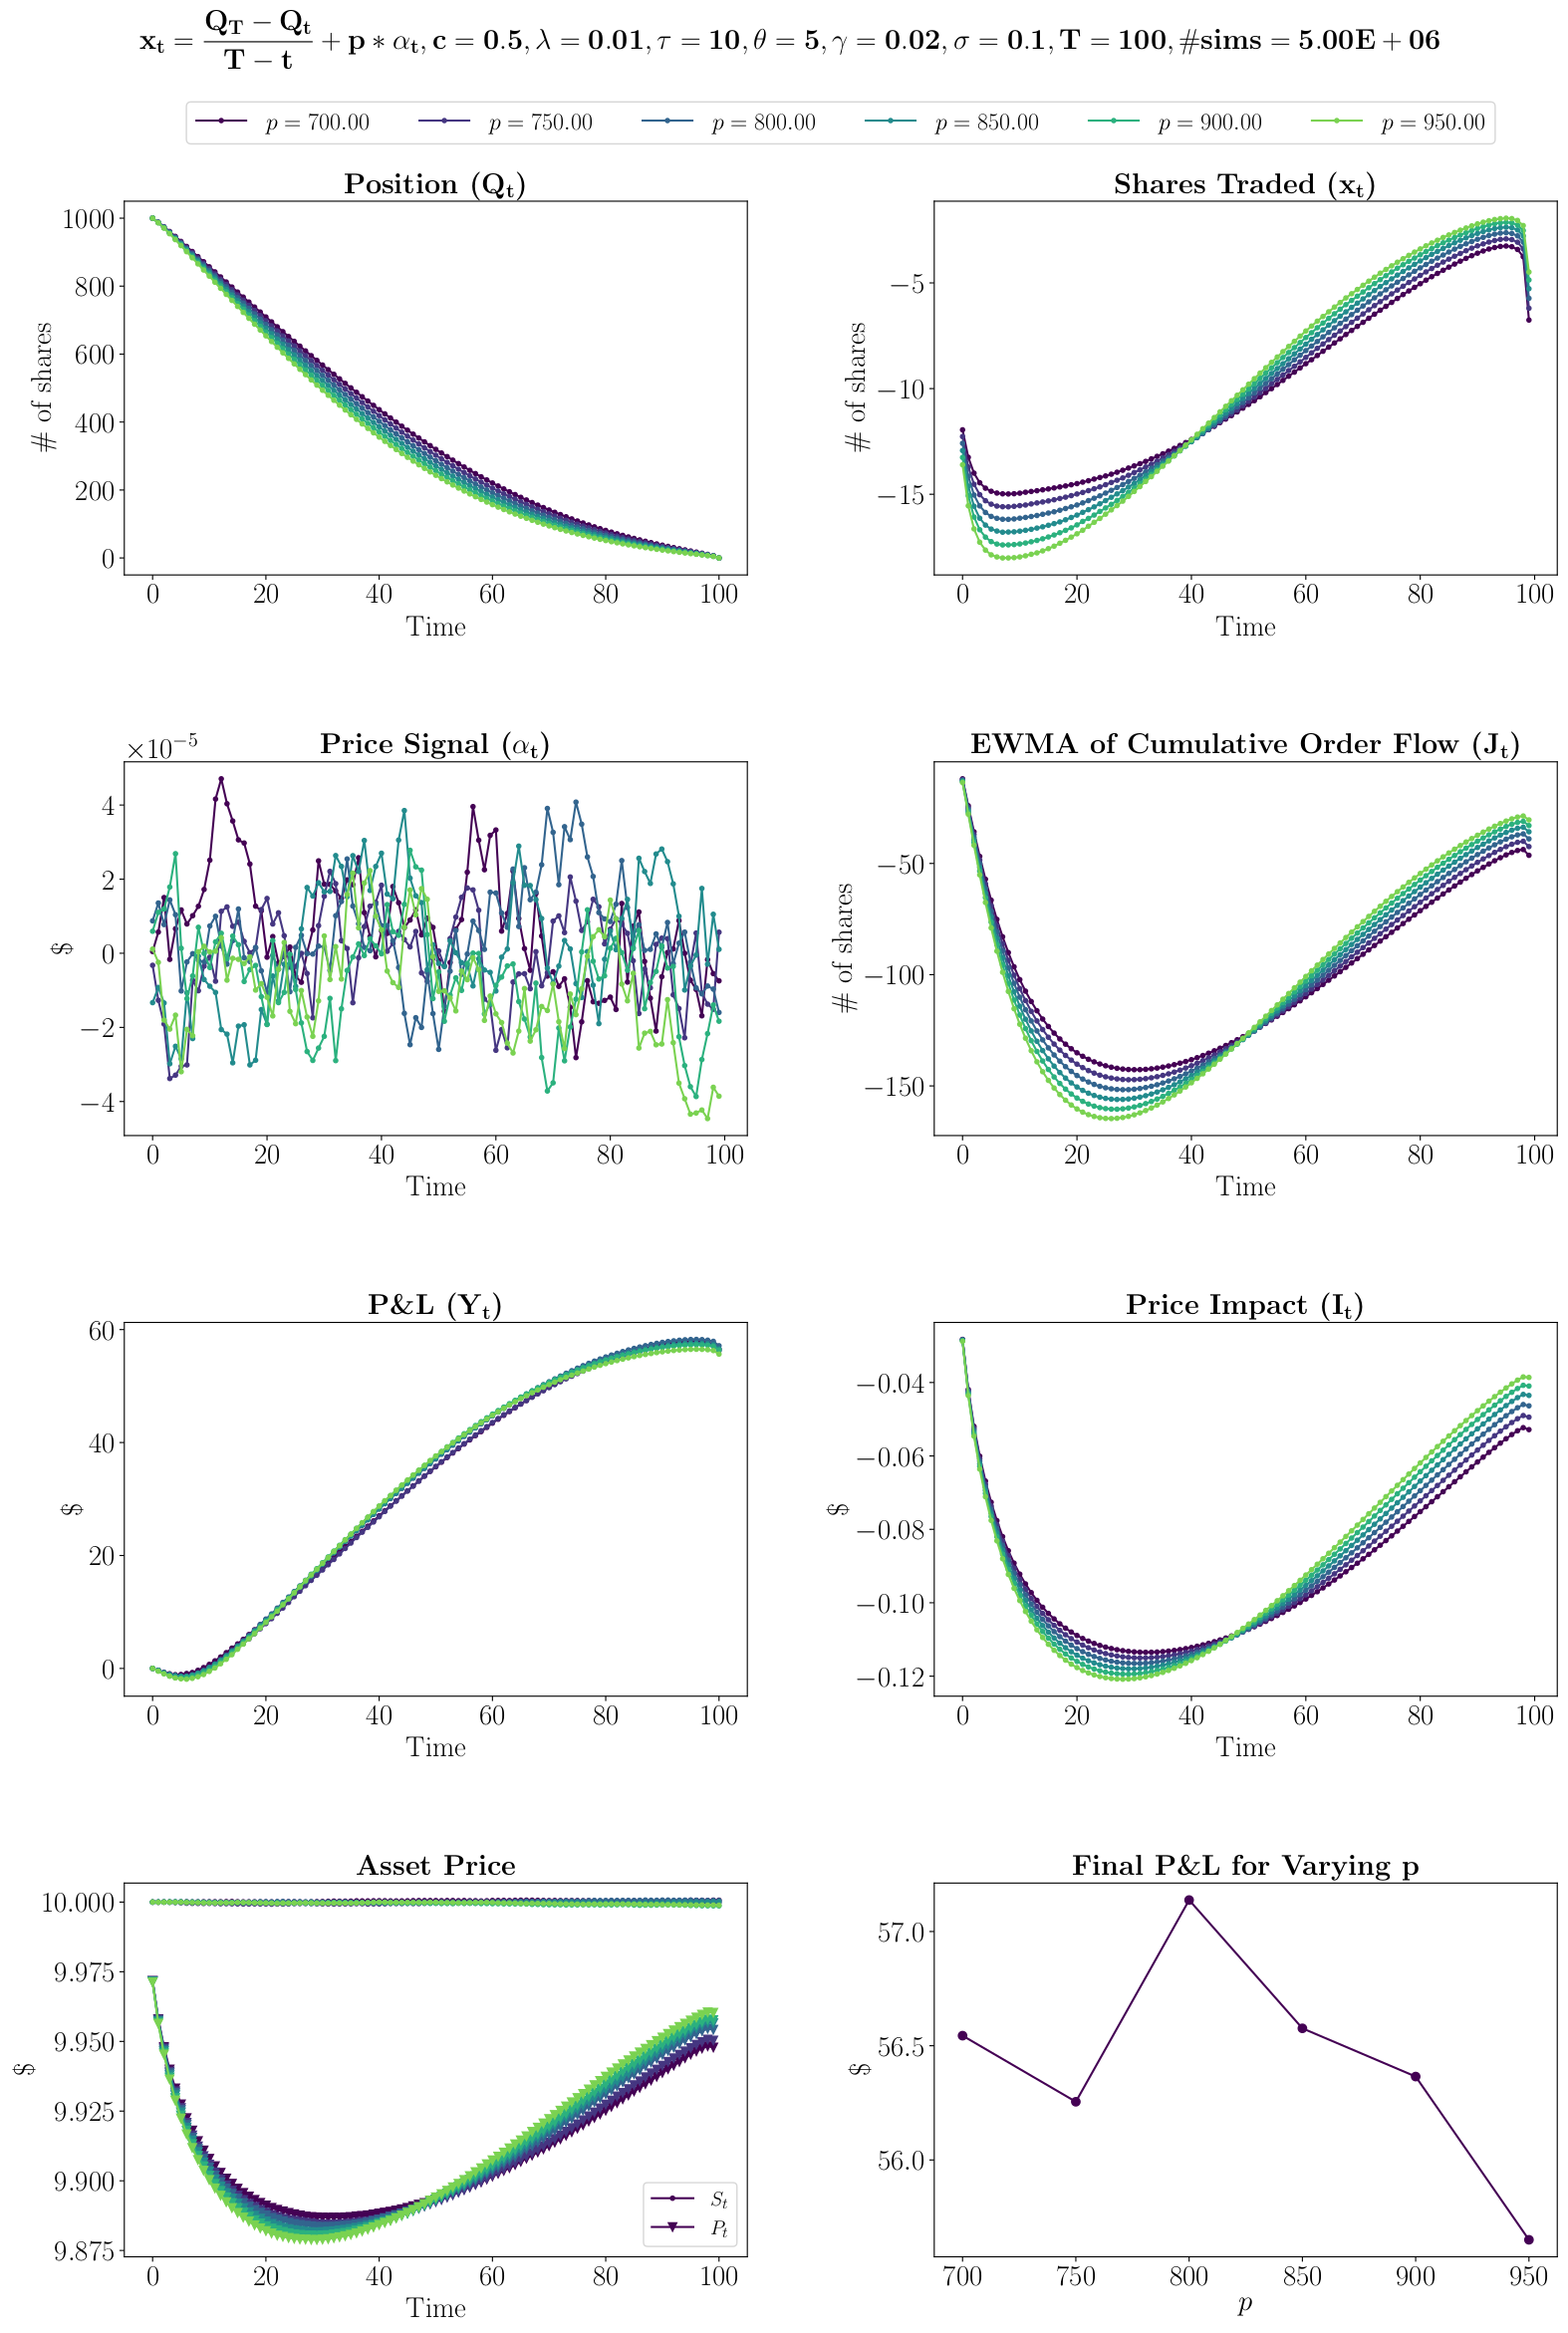

In [160]:
file_path = '/scratch/network/efyoung/seniorthesis/sims/5M-700-950-251.pkl'
with open(file_path, 'rb') as file:
    d = pickle.load(file)
ps = [700.0,750.0,800.0,850.0,900.0,950.0]
df = {}
for p in ps:
    d[p]['Y'] = d[p]['Y']-10000
    df[p] = d[p]

params = {
    'init_q': 1000,
    'target_q': 0,
    'c': 0.5,
    'lamb': 0.01,
    'tau': 10,
    'theta': 5,
    'gamma': 0.02,
    'T': 100,
    'sigma': 0.1,
    'n_MC': 5000000,
}
plot_multi_results(rf"$\mathbf{{x_t=\frac{{Q_T-Q_t}}{{T-t}}+p*\alpha_t,c={params['c']},\lambda={params['lamb']},\tau={params['tau']},\theta={params['theta']},\gamma={params['gamma']},\sigma={params['sigma']},T={params['T']},\#sims={params['n_MC']:.2E}}}$", df, save_fig=True, fpath = "/scratch/network/efyoung/seniorthesis/plots/mul_p.pdf")

In [158]:
file_paths = ['/scratch/network/efyoung/seniorthesis/sims/5M-0-2000-251.pkl', 
             '/scratch/network/efyoung/seniorthesis/sims/5M-400-1200-251.pkl', 
             '/scratch/network/efyoung/seniorthesis/sims/5M-600-1050-251.pkl', 
             '/scratch/network/efyoung/seniorthesis/sims/5M-700-950-251.pkl'
            ]
ncols = 2
N = 4
fig, axes = plt.subplots(ncols = ncols, nrows = math.ceil(N/ncols), layout='constrained', figsize=(8*ncols, 6 * math.ceil(N/ncols)))
titles = [r"$\mathbf{{p\in[0,2000]}}$", r"$\mathbf{{p\in[400,1200]}}$", r"$\mathbf{{p\in[600,1050]}}$", r"$\mathbf{{p\in[700,950]}}$"]
for i, file_path in enumerate(file_paths):
    with open(file_path, 'rb') as file:
        d = pickle.load(file)
        
        final_Y = np.array([d[x]['Y'].iloc[-1] for x in d.keys()])
        final_Y = final_Y - 10000
    
        axes[i//2, i%2].plot(d.keys(), final_Y, '.')
        if i == 3:
            x_vals = np.linspace(700, 950, 1001)
            y_vals = 18.73995574 + 0.0939472*x_vals - (5.77031069e-05)*x_vals**2
            axes[i//2, i%2].plot(x_vals, y_vals, lw = 8, c = 'r')
        if i == 2:
            x_vals = np.linspace(600, 1050, 1001)
            y_vals = 19.43311137 + 0.09061961*x_vals - (5.46641331e-05)*x_vals**2
            axes[i//2, i%2].plot(x_vals, y_vals, lw = 8, c = 'r')
        axes[i//2, i%2].set_title(titles[i], fontweight = 'heavy')
        axes[i//2, i%2].set_xlabel(r"$p$")
        axes[i//2, i%2].set_ylabel(r"P\&L (\$)")
        axes[i//2, i%2].ticklabel_format(style='sci',axis='both')
        
fig.suptitle(fr"\textbf{{Final P\&L for Varying $\mathbf{{p}}$, \#sims={5000000:.2E}}}", fontsize = 20, fontweight = "heavy")
fig.savefig("/scratch/network/efyoung/seniorthesis/plots/all_p_ranges.pdf", bbox_inches='tight', dpi = 600)

/tmp/ipykernel_895554/2733710939.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


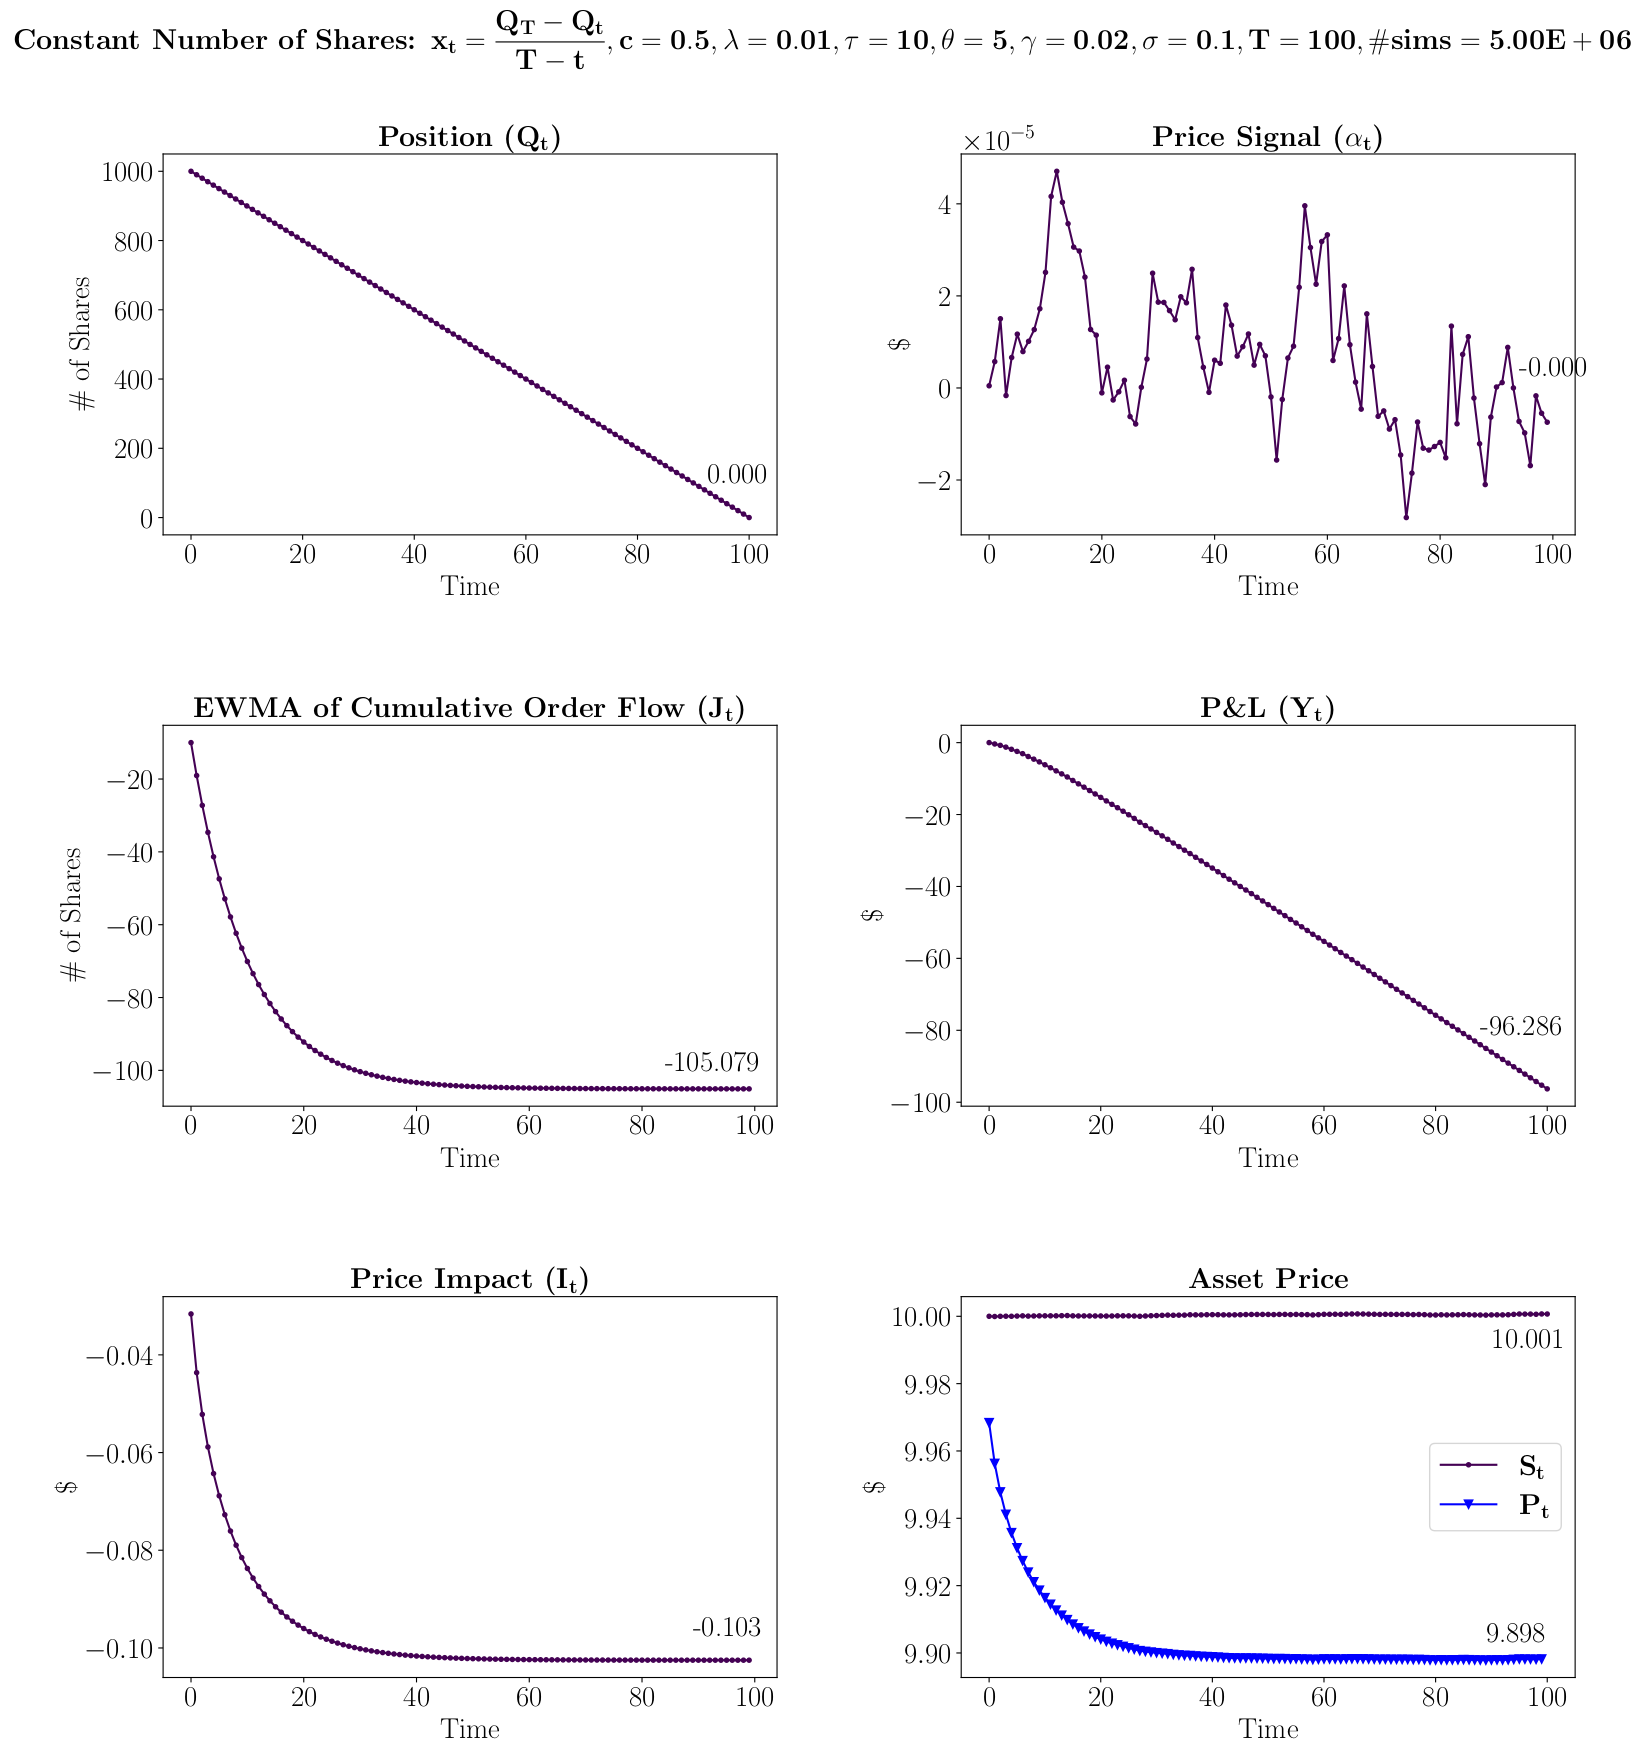

In [159]:
file_path = '/scratch/network/efyoung/seniorthesis/sims/5M-0-2000-251.pkl'
with open(file_path, 'rb') as file:
    df = pickle.load(file)[0.0]
df['Y'] = df['Y'] - 10000

params = {
    'init_q': 1000,
    'target_q': 0,
    'c': 0.5,
    'lamb': 0.01,
    'tau': 10,
    'theta': 5,
    'gamma': 0.02,
    'T': 100,
    'sigma': 0.1,
    'n_MC': 5000000,
}
plot_results(fr"Constant Number of Shares: $\mathbf{{x_t=\frac{{Q_T-Q_t}}{{T-t}},c={params['c']},\lambda={params['lamb']},\tau={params['tau']},\theta={params['theta']},\gamma={params['gamma']},\sigma={params['sigma']},T={params['T']},\#sims={params['n_MC']:.2E}}}$", df, save_fig = True, fpath = "/scratch/network/efyoung/seniorthesis/plots/5M-0-2000-251.pdf")
# plt.close()